<a href="https://colab.research.google.com/github/doggerator/ML/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 6
## Гомография
Задание 1: взять код и сделать самостоятельно панараму больше чем на 2-х снимках,
Задание 2: взять код который занимается триангуляцией на основе афинной гомографии, придумать и реализовать метод автоматического триангулирования (по ключивым точкам лица с помошбю нейронки, взять шар и по окружности триангулировать) и приминить для своей фотографии.
код в виде архива и презентация


# Панарама

код взят из switching.py

In [ ]:
!python switching.py

[ WARN:0@0.037] global shadow_sift.hpp:15 cv::xfeatures2d::SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


## Оригинальные изображения

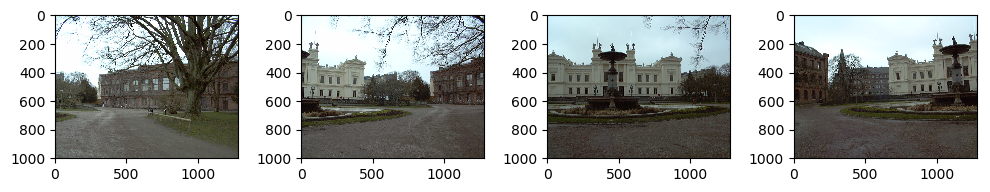

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
for i, image_pat in enumerate(['data/Univ1.jpg','data/Univ2.jpg','data/Univ3.jpg','data/Univ4.jpg']):
    image = plt.imread(image_pat)
    axs.flat[i].imshow(image)
plt.tight_layout()
plt.show()

## Панарама на 4-х снимках

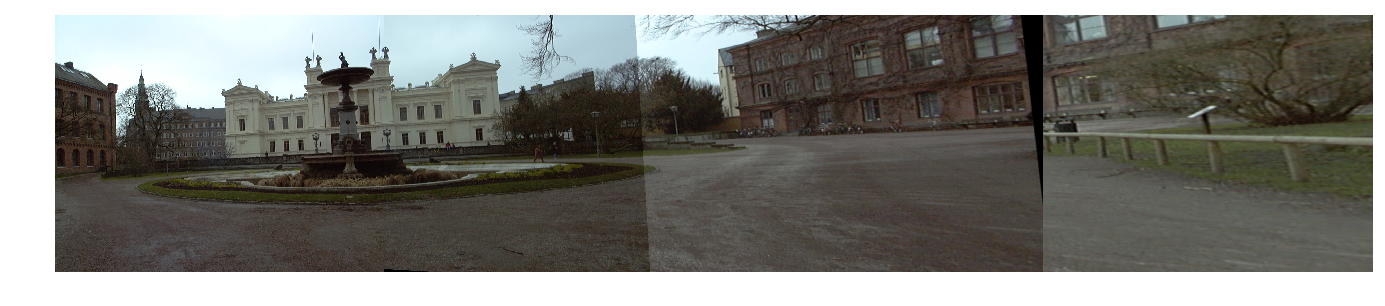

In [ ]:
import cv2
import numpy as np

def get_h(img1, img2):
    # Преобразование изображений в оттенки серого
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Инициализация объекта SIFT (определение ключевых точек)
    sift = cv2.xfeatures2d.SIFT_create()

    # Нахождение ключевых точек и дескрипторов на обоих изображениях
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    # Нахождение соответствий между дескрипторами на двух изображениях
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    matches = matcher.knnMatch(des1, des2, k=2)

    # Фильтрация соответствий с помощью метрики Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Нахождение матрицы гомографии
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H

def append(img1, img2):
    H = get_h(img1, img2)
    # Преобразование изображений
    panorama = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img2.shape[0]))
    panorama[0:img2.shape[0], 0:img2.shape[1]] = img2
    return panorama

# Загрузка изображений
img1 = cv2.imread('data/Univ1.jpg')
img2 = cv2.imread('data/Univ2.jpg')
img3 = cv2.imread('data/Univ3.jpg')
img4 = cv2.imread('data/Univ4.jpg')

# Преобразование по две фотки в правильном порядке
panorama = append(img2, img3) # две средние
panorama = append(panorama, img4) # крайняя справа
panorama = append(img1, panorama) # крайняя слева
plt.figure(figsize = (17,10))
plt.axis('off')
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB), interpolation='nearest')

# Триангуляция

## triangles_vidio.py в видеопатоке находит прямаугольники черного цвета на белом боне и заменяет их на изображение автоматически триангулируя его.

## Пример для фотографии

#### Исходные фото

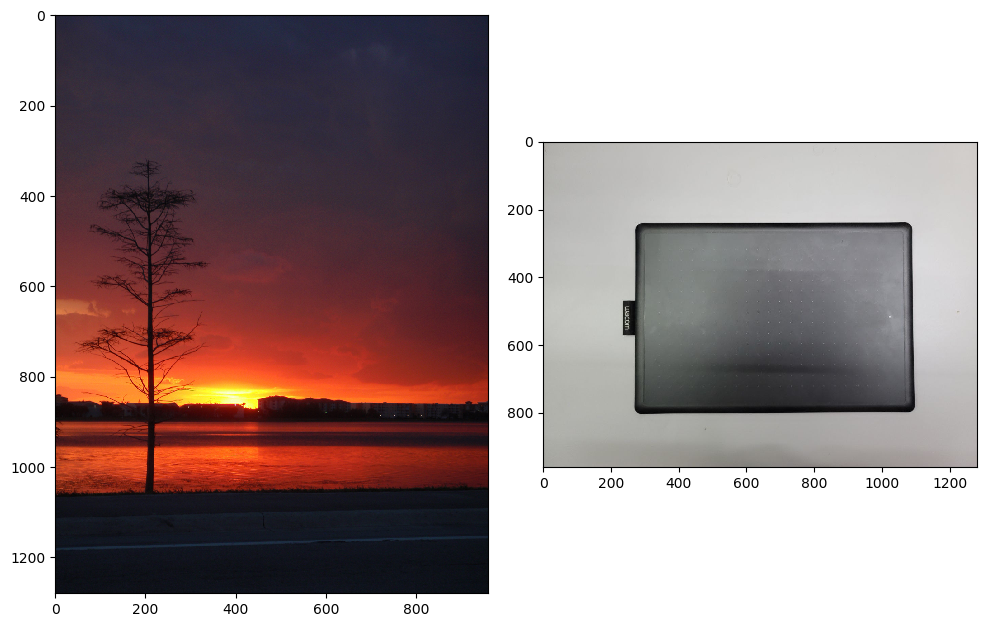

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
for i, image_pat in enumerate(['data/sunset_tree.jpg','data/tablet.jpg']):
    image = plt.imread(image_pat)
    axs.flat[i].imshow(image)
plt.tight_layout()
plt.show()

#### Автоматическая триангуляция на основе обнаружения прямаугольников на фото

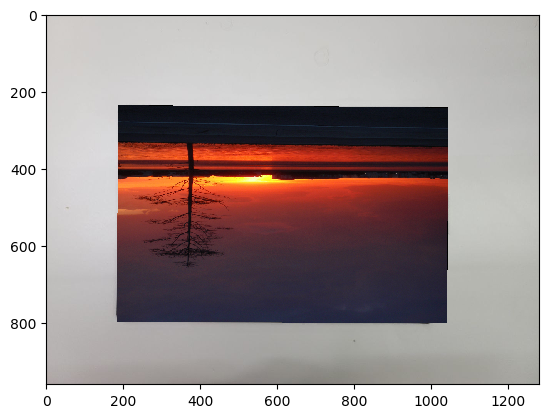

In [ ]:
import cv2
import numpy as np
import warp
import matplotlib.pyplot as plt
# установка диапазона для установки порога
# чёрные объекты на белом фоне
hsv_min = np.array((0, 0, 0), np.uint8)
hsv_max = np.array((255,255,60), np.uint8)

# открыть изображение для деформации
fromim = np.array(cv2.imread('data/sunset_tree.jpg'))
x,y = np.meshgrid(range(5),range(6))
x = (fromim.shape[1]/4) * x.flatten()
y = (fromim.shape[0]/5) * y.flatten()
x = np.array([0, fromim.shape[1],0, fromim.shape[1]])
y = np.array([0,0, fromim.shape[0], fromim.shape[0]])
# Триангуляция
tri = warp.triangulate_points(np.stack((x, y), axis=1)).simplices

img = np.array(cv2.imread('data/tablet.jpg'))
img = cv2.flip(img,1)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV ) # конвертация обратно в цвет
thresh = cv2.inRange(hsv, hsv_min, hsv_max) # пороговая функция
# поиск прямоугольников на изображении для вставки картинки (4 координаты)
contours0, hierarchy = cv2.findContours( thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

for cnt in contours0: # проходимся по прямоугольникам
    rect = cv2.minAreaRect(cnt) # преобразование в векторные данные
    box = cv2.boxPoints(rect) # поиск углов
    box = np.array([box[0],box[3],box[1],box[2]]) # переставляем углы для адекватной триангуляции
    box = np.int0(box)
    t = box.T
    # обрезка изображения
    t[0] =np.clip(t[0], 0, img.shape[1])
    t[1] =np.clip(t[1], 0, img.shape[0])
    box = t.T
    area = int(rect[1][0]*rect[1][1]) # площадь изображения
    if area > 500: # при достаточной площади
        # конвертировать точки в однородные координаты
        fp = np.vstack((y,x,np.ones((1,len(x)))))
        box =np.vstack((box[:,1],box[:,0],np.ones((1,len(box)))))
        # деформация треугольников
        img = warp.pw_affine(fromim.copy(),img,fp,box,tri)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))